In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer

In [2]:
# Métrica de evaluación
def RMSLE(actual, pred):
    actualLog = np.log(actual + 1)
    predLog = np.log(pred + 1)
    return (np.mean((actualLog - predLog) ** 2)) **.5

In [3]:
def normailize_df(refDf, train):
    df = refDf.copy()
    df['año'] = df['fecha'].dt.year
    df['antiguedad'] = df['antiguedad'] + (2016 - df['año']) # Se normaliza la antiguedad.
    df.antiguedad = df.antiguedad.fillna(0) #Asumo que si no tiene antiguedad entonces es nuevo
    df.drop(["direccion", 'descripcion', 'lat', 'lng', 'fecha', 'ciudad', 'provincia', 'titulo'], axis=1, inplace=True)
    
    nulltotales = df[df['metrostotales'].isnull()]
    nullcubiertos = df[df['metroscubiertos'].isnull()]
    notnullapart = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] < df['metroscubiertos'])]
    notnullapart2 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] > df['metroscubiertos'])]
    notnullapart3 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] == df['metroscubiertos'])]
 
    df['habitable'] = False
    tipodepropiedades = df.tipodepropiedad.cat.categories.to_list()
    for tipodepropiedad in tipodepropiedades: 
              
        idsNullMetrosTotales = (df.tipodepropiedad == tipodepropiedad) & (df.metrostotales.isnull())
        idsNullMetrosCubiertos = (df.tipodepropiedad == tipodepropiedad) & (df.metroscubiertos.isnull())
        banos = df[df.tipodepropiedad == tipodepropiedad].banos.mode(dropna=False);
        habitaciones = df[df.tipodepropiedad == tipodepropiedad].habitaciones.mode(dropna=False);

        ## Verificamos si la cantidad de registros con metros cubiertos nulos es mayor a 2/5 de los totales. Si es asi 
        ## los consideramos propiedades no habitables. Y los tratamos de manera diferente
        if(len(nullcubiertos[nullcubiertos.tipodepropiedad == tipodepropiedad]) >= 2/5* len(df[df.tipodepropiedad == tipodepropiedad])):
            df.metrostotales.fillna(0, inplace=True)
            df.metroscubiertos.fillna(0, inplace=True)
        else:
            df[idsNullMetrosTotales]['metrostotales'] =  df[idsNullMetrosTotales]['metroscubiertos']
            df[idsNullMetrosCubiertos]['metroscubiertos'] =  df[idsNullMetrosCubiertos]['metrostotales']

        #Si la moda del tipo de propiedad de banos y habitaciones son ambas distintas de nan entonces la propiedad es habitable.

        df.loc[(df.tipodepropiedad == tipodepropiedad), 'habitable'] = not(np.isnan(banos[0]) and np.isnan(habitaciones[0]))
    
    df['metros'] = df['metrostotales'] + df['metroscubiertos']
    df.habitaciones = df.habitaciones.fillna(0)
    df.garages = df.garages.fillna(0)
    df.banos = df.banos.fillna(0)
    df.idzona = df.idzona.fillna(50003995.0) # IDZona calculado que es la moda

    
    if(train):

        df.dropna(subset=['tipodepropiedad'],inplace=True)
        def is_outlier(group):
            Q1 = group.quantile(0.25)
            Q3 = group.quantile(0.75)
            IQR = Q3 - Q1
            precio_min = Q1 - 1.5 * IQR
            precio_max = Q3 + 1.5 * IQR
            return ~group.between(precio_min, precio_max)
        df['precio_mt2'] = df['precio'] / df['metros']
        print()
        
        df = df[~df.groupby('tipodepropiedad')['precio_mt2'].apply(is_outlier).fillna(False)]
        idDel = df_train[df_train.tipodepropiedad == 'Garage'].index
        df = df.drop(idDel)
        idDel = df_train[df_train.tipodepropiedad == 'Hospedaje'].index
        df = df.drop(idDel)
        print('Despues de filtrar: ', df.shape)
    else:
        df.tipodepropiedad = df.tipodepropiedad.fillna('Casa')   #El tipo de propiedad mas comun
    return df

In [4]:
#Archivos de train y test

df_train = pd.read_csv('data/train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
df_test = pd.read_csv('data/test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_train = normailize_df(df_train, True)
df_test = normailize_df(df_test, False)

tiposdepropiedades = df_train.tipodepropiedad.cat.categories.to_list()

cols = list(df_train.columns)
cols =  cols[:13] + cols[14:] +[cols[13]]
df_train = df_train[cols]



/home/rama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rama/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Despues de filtrar:  (223429, 18)


In [5]:
errors = []
calcRange = (1, 10)
for propiedad in tiposdepropiedades:
    print(propiedad)
    X = df_train[df_train.tipodepropiedad == propiedad].iloc[:, 1:-2].values
    y = df_train[df_train.tipodepropiedad == propiedad].precio.values
    if len(X) == 0:
        continue
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
   
    error = []
    # Calculating error for K values between 4 and 15
    for i in range(calcRange[0],calcRange[1]):
        print(i)
        if len(X_train) < i:
            print("X tiene de len :", len(X_train))
            continue
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, y_train)
        pred_i = knn.predict(X_test)
        error.append(RMSLE(y_test,pred_i))
    
    errors.append((propiedad,error))


    

Apartamento
1
2
3
4
5
6
7
8
9
Bodega comercial
1
2
3
4
5
6
7
8
9
Casa
1
2
3
4
5
6
7
8
9
Casa en condominio
1
2
3
4
5
6
7
8
9
Casa uso de suelo
1
2
3
4
5
6
7
8
9
Departamento Compartido
1
2
3
4
5
6
7
8
9
Duplex
1
2
3
4
5
6
7
8
9
Edificio
1
2
3
4
5
6
7
8
9
Huerta
1
2
3
4
5
6
7
8
9
Inmuebles productivos urbanos
1
2
3
4
5
6
7
8
9
Local Comercial
1
2
3
4
5
6
7
8
9
Local en centro comercial
1
2
3
4
5
6
7
8
9
Lote
1
2
3
4
X tiene de len : 3
5
X tiene de len : 3
6
X tiene de len : 3
7
X tiene de len : 3
8
X tiene de len : 3
9
X tiene de len : 3
Nave industrial
1
2
3
4
5
6
7
8
9
Oficina comercial
1
2
3
4
5
6
7
8
9
Otros
1
2
3
4
5
6
7
8
9
Quinta Vacacional
1
2
3
4
5
6
7
8
9
Rancho
1
2
3
4
5
6
7
8
9
Terreno
1
2
3
4
5
6
7
8
9
Terreno comercial
1
2
3
4
5
6
7
8
9
Terreno industrial
1
2
3
4
5
6
7
8
9
Villa
1
2
3
4
5
6
7
8
9
Hospedaje
Garage


Apartamento


Text(0, 0.5, 'RMSLE Error')

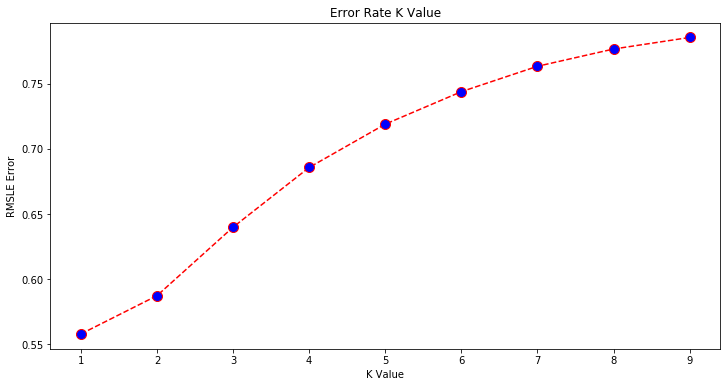

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[0][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[0][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')


Bodega comercial


Text(0, 0.5, 'RMSLE Error')

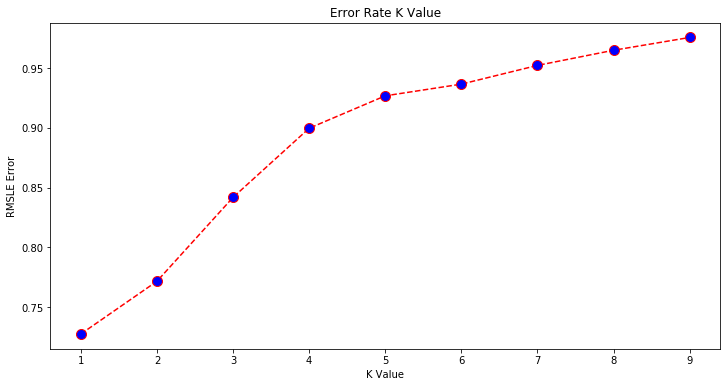

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[1][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[1][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Casa


Text(0, 0.5, 'RMSLE Error')

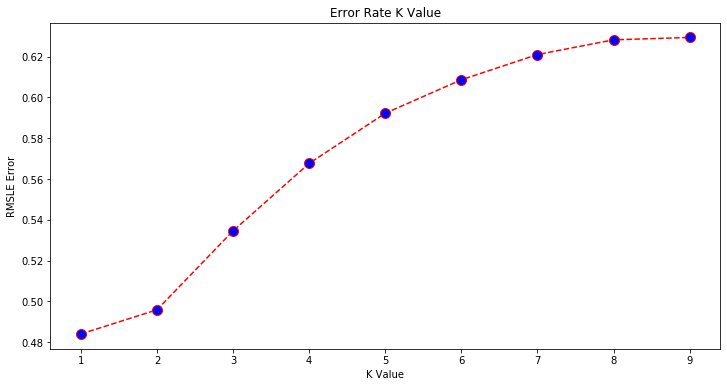

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[2][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[2][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Casa en condominio


Text(0, 0.5, 'RMSLE Error')

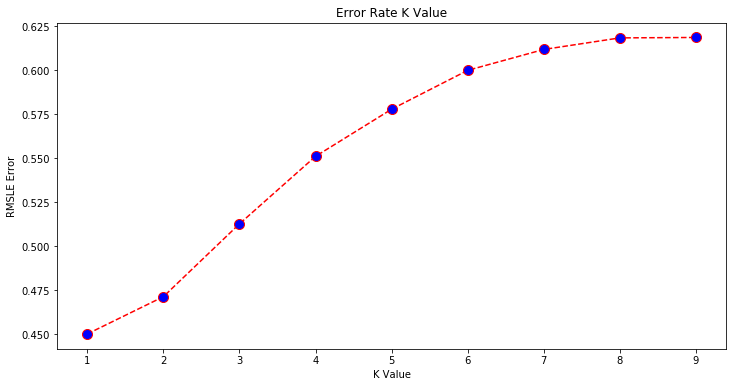

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[3][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[3][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Casa uso de suelo


Text(0, 0.5, 'RMSLE Error')

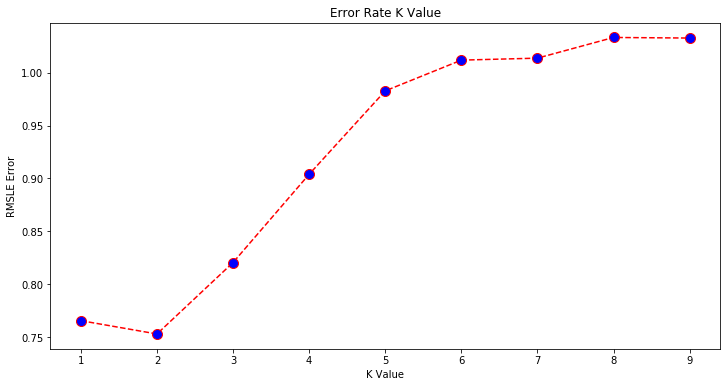

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[4][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[4][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Departamento Compartido


Text(0, 0.5, 'RMSLE Error')

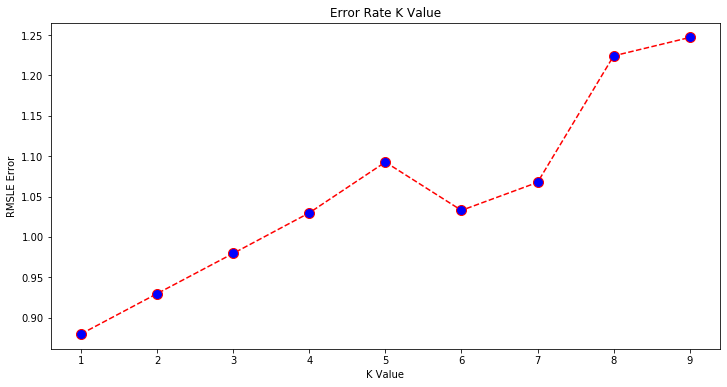

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[5][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[5][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Duplex


Text(0, 0.5, 'RMSLE Error')

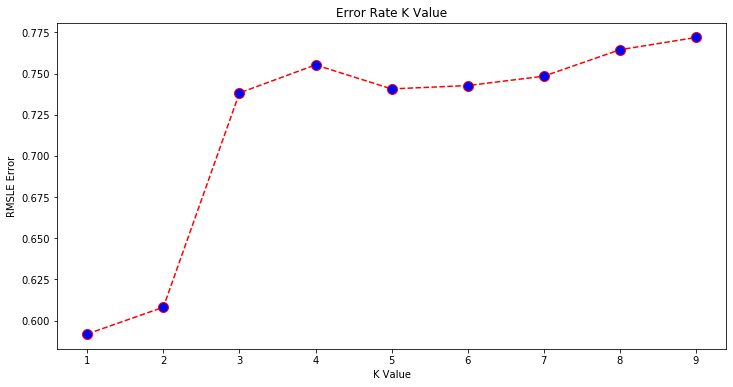

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[6][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[6][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Edificio


Text(0, 0.5, 'RMSLE Error')

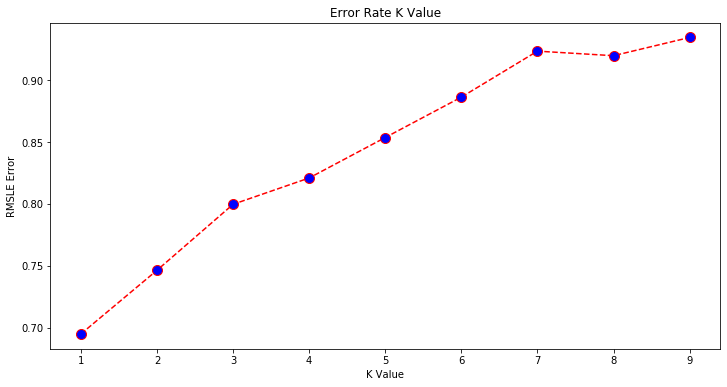

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[7][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[7][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Huerta


Text(0, 0.5, 'RMSLE Error')

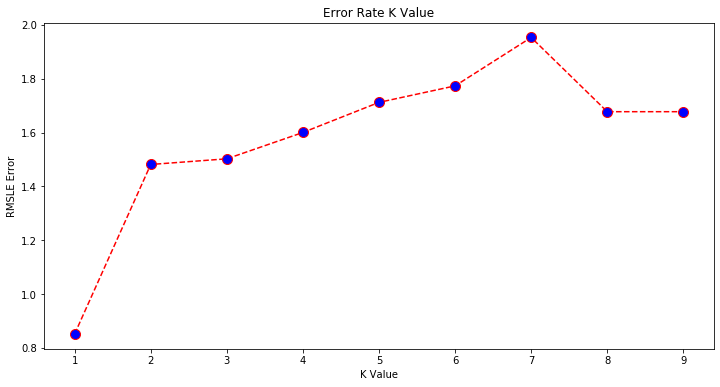

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,10), errors[8][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[8][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Inmuebles productivos urbanos


Text(0, 0.5, 'RMSLE Error')

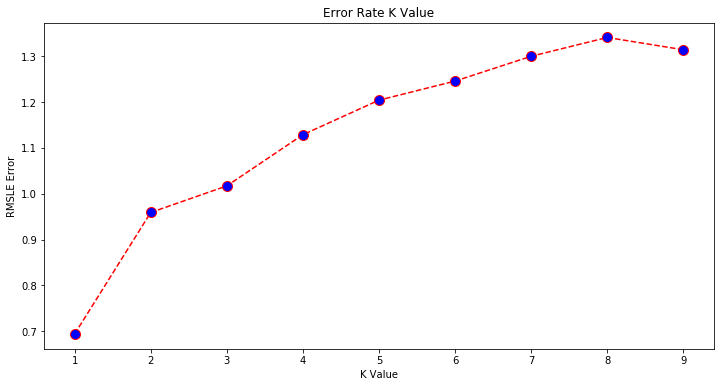

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[9][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[9][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Local Comercial


Text(0, 0.5, 'RMSLE Error')

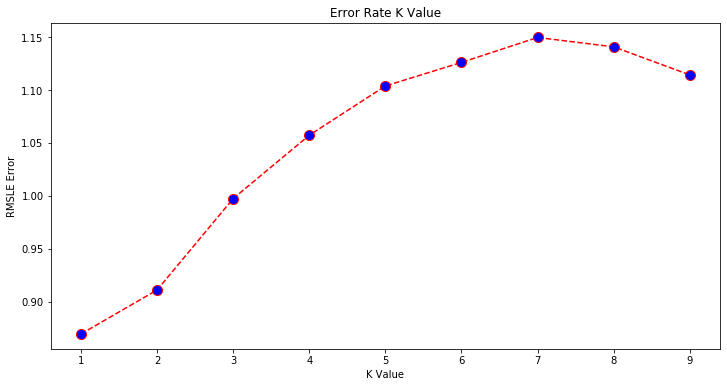

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[10][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[10][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Local en centro comercial


Text(0, 0.5, 'RMSLE Error')

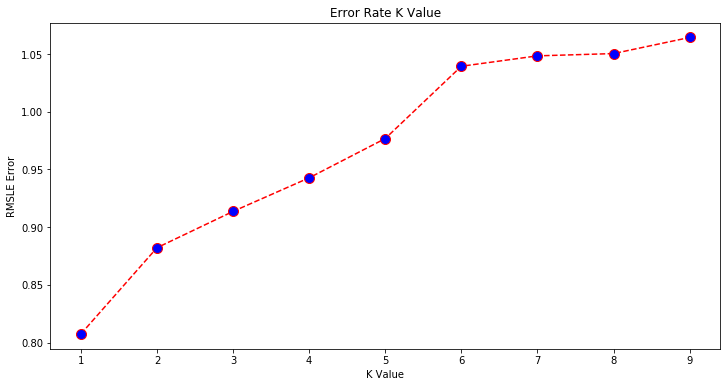

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[11][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[11][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Lote


Text(0, 0.5, 'RMSLE Error')

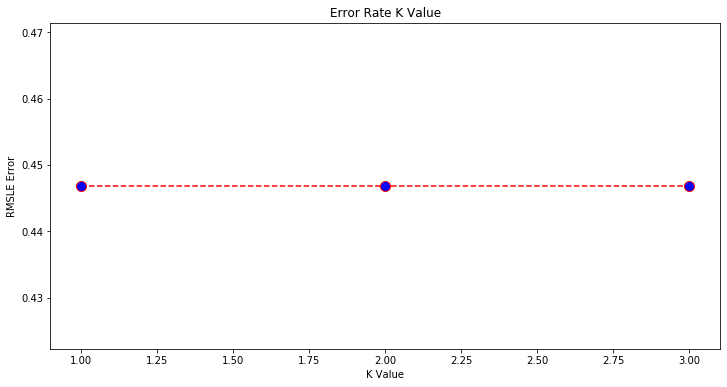

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(range(1,4), errors[12][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[12][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Nave industrial


Text(0, 0.5, 'RMSLE Error')

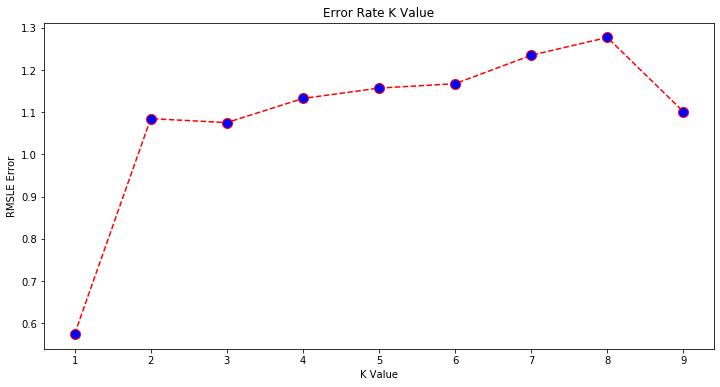

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[13][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[13][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Oficina comercial


Text(0, 0.5, 'RMSLE Error')

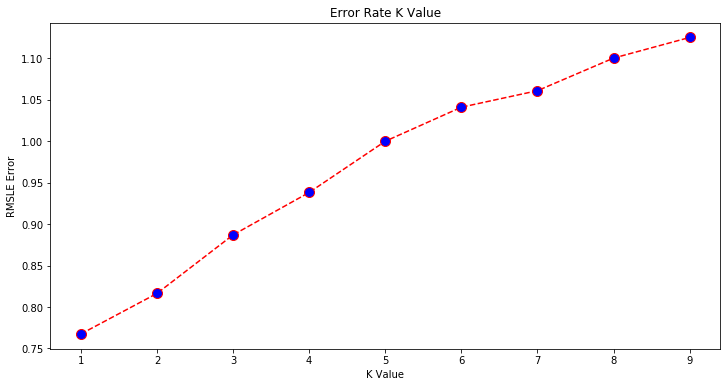

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[14][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[14][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Otros


Text(0, 0.5, 'RMSLE Error')

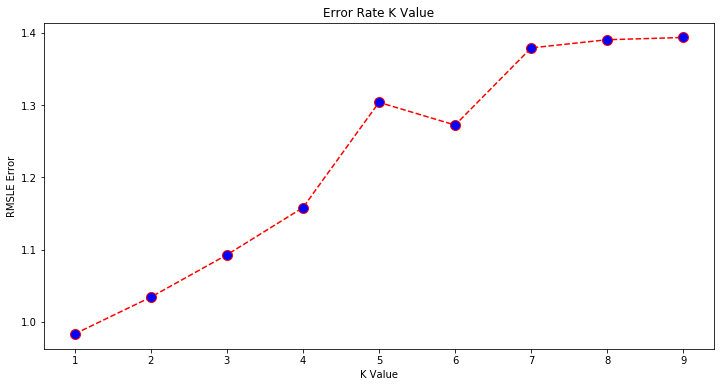

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[15][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[15][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Quinta Vacacional


Text(0, 0.5, 'RMSLE Error')

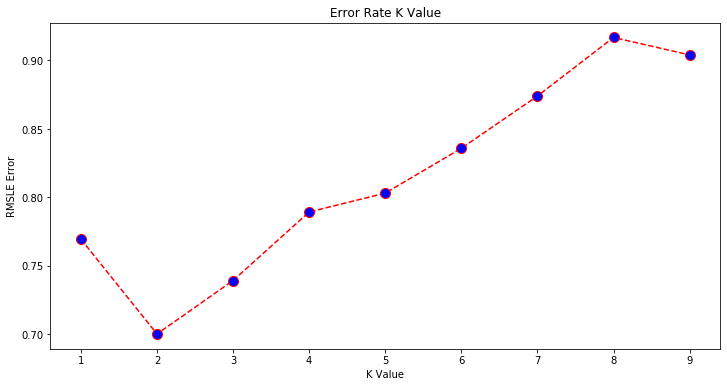

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[16][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[16][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Rancho


Text(0, 0.5, 'RMSLE Error')

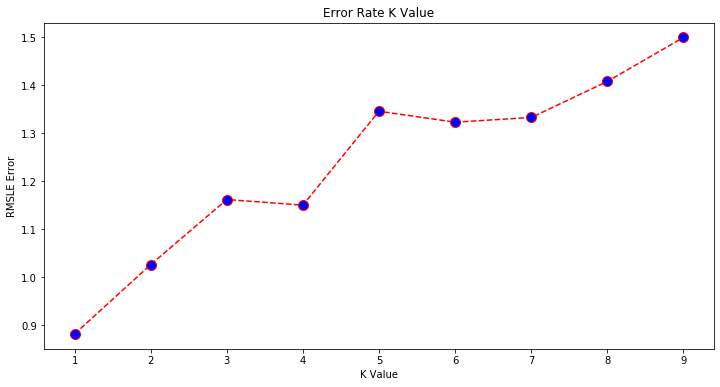

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[17][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[17][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Terreno


Text(0, 0.5, 'RMSLE Error')

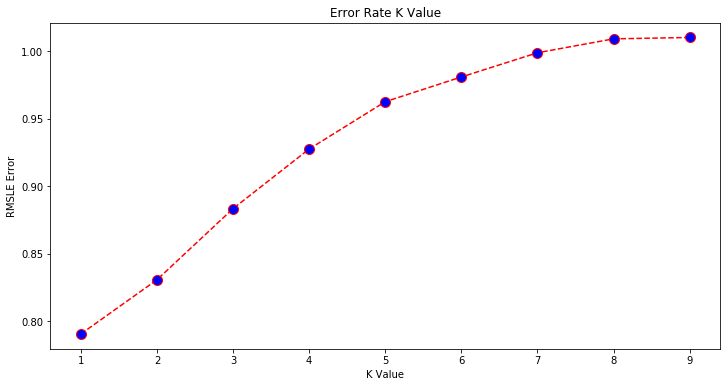

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[18][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[18][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Terreno comercial


Text(0, 0.5, 'RMSLE Error')

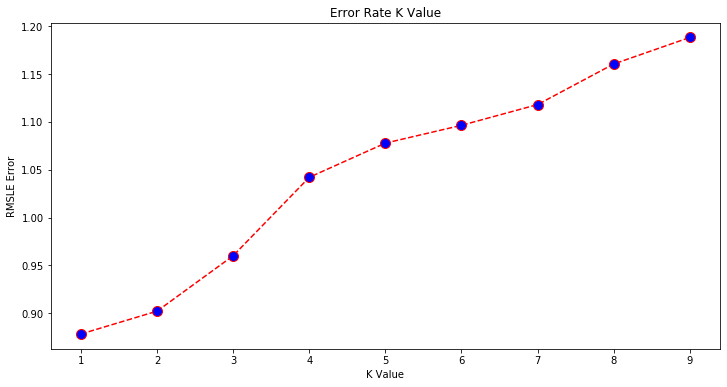

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[19][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[19][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Terreno industrial


Text(0, 0.5, 'RMSLE Error')

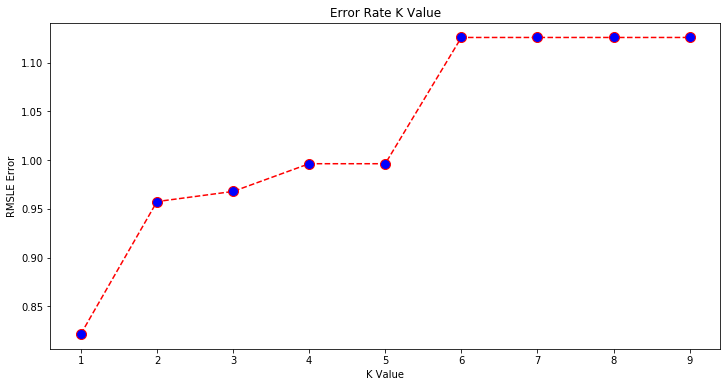

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[20][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[20][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

Villa


Text(0, 0.5, 'RMSLE Error')

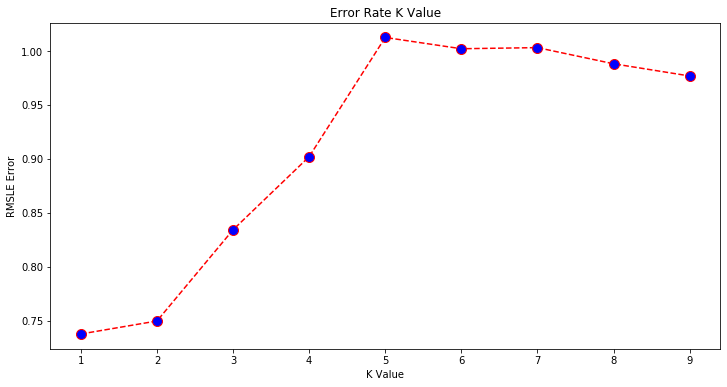

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(range(calcRange[0],calcRange[1]), errors[21][1], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
print(errors[21][0])
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('RMSLE Error')

In [67]:
idMinErrors=[]

for prop in range(0,len(errors)):
    df = pd.DataFrame(data = errors[prop][1], columns=['errores'])
    indice = df.index
    df['nuevoIdx'] = indice + 2 
    df = df.set_index('nuevoIdx')
    idMinErrors.append(df.errores.idxmin())

idMinErrors

[2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2]

In [115]:
contador = 0
res
for propiedad in tiposdepropiedades:
    

    X = df_train[df_train.tipodepropiedad == propiedad].iloc[:, 1:-2].values
    y = df_train[df_train.tipodepropiedad == propiedad].precio.values
    X_test = df_test[df_test.tipodepropiedad == propiedad].iloc[:, 1:].values
    if len(X) == 0:
        continue
    
    print(propiedad)
    print(idMinErrors[contador])
    
    scaler = StandardScaler()
    scaler.fit(X)

    X_train = scaler.transform(X)
    X_test = scaler.transform(X_test)
    
    knn = KNeighborsClassifier(n_neighbors=idMinErrors[contador])
    knn.fit(X, y)

    pred_KNN = knn.predict(X_test)
    if contador == 0:
        res = pd.DataFrame(pred_KNN, index=df_test[df_test.tipodepropiedad == propiedad].index, columns=['target'])\
                    .reset_index()
    else:
        actualDf = pd.DataFrame(pred_KNN, index=df_test[df_test.tipodepropiedad == propiedad].index, columns=['target'])\
                    .reset_index()
        res = res.append(actualDf)
    contador += 1
res = res.set_index('id')

Apartamento
2
Bodega comercial
2
Casa
2
Casa en condominio
2
Casa uso de suelo
3
Departamento Compartido
2
Duplex
2
Edificio
2
Huerta
2
Inmuebles productivos urbanos
2
Local Comercial
2
Local en centro comercial
2
Lote
2
Nave industrial
2
Oficina comercial
2
Otros
2
Quinta Vacacional
3
Rancho
2
Terreno
2
Terreno comercial
2
Terreno industrial
2
Villa
2


In [118]:
display(res.head())
res.to_csv("data/workshop-submission-knnFinal.csv", header=True)

,target
id,
51775,440000.0
115253,440000.0
299321,440000.0
148208,440000.0
238663,440000.0
